# PREDICCION DE PRECIOS DE AGUACATE EN EEUU





# Enunciado del Problema

- Los datos representan ventas semanales desde 2015 a 2018 a nivel de todos los EEUU. 
- Los datos provienen directamente de las cajas registradoras basados en ventas de aguacate variedad Hass. 
- El precio promedio de los aguacates reflejan el costo por unidad, aún cuando estos se vendan por bolsas. 
- Los códigos (Product Lookup codes ó PLU) en la tabla son solo de aguacates Hass.  No se incluyen otras variedades.

Columnas relevantes en el conjunto de datos:

- Date - la fecha de la observación
- AveragePrice - el precio promedio de una unidad
- type - convencional u orgánico
- year - el año
- Region - la ciudad o región de la observación
- Total Volume - número total de aguacates vendidos
- 4046 - número total de aguacates con PLU 4046 vendidos
- 4225 - número total de aguacates con PLU 4225 vendidos
- 4770 - número total de aguacates con PLU 4770 vendidos



# Importar las librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor


ModuleNotFoundError: No module named 'autogluon'

# Carga de datos

In [53]:
df = pd.read_csv('aguacates_EEUU.csv')

In [52]:
df['type'].unique()

array(['conventional', 'organic'], dtype=object)

# Explorar el conjunto de datos  

In [54]:
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [55]:
df.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

# Asegurar que estén los datos en orden cronológico

In [56]:
df.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

Convertimos la columna fecha en tipo fecha

In [57]:
df['Date'] = pd.to_datetime(df['Date'])

In [58]:
df.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
dtype: object

In [59]:
df = df.sort_values ('Date')
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast
9593,51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,organic,2015,Chicago
10009,51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,2015,HarrisburgScranton
1819,51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,2015,Pittsburgh
9333,51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,organic,2015,Boise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8574,0,2018-03-25,1.36,908202.13,142681.06,463136.28,174975.75,127409.04,103579.41,22467.04,1362.59,conventional,2018,Chicago
9018,0,2018-03-25,0.70,9010588.32,3999735.71,966589.50,30130.82,4014132.29,3398569.92,546409.74,69152.63,conventional,2018,SouthCentral
18141,0,2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.00,organic,2018,SouthCentral
17673,0,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California


# Realizar una gráfica de precios promedio vrs fecha

¿Cuál es la tendencia a nivel nacional?

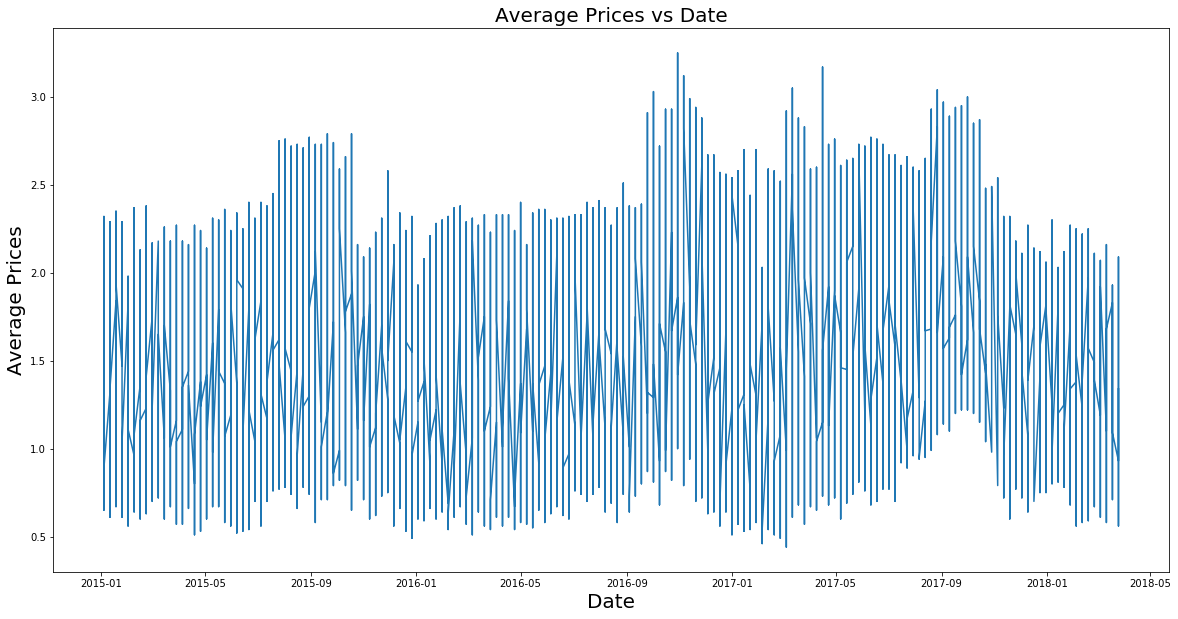

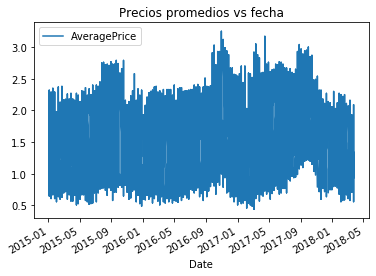

In [60]:
plt.figure(figsize=(20,10))
plt.plot(df['Date'],df['AveragePrice'])
plt.title('Average Prices vs Date',size = 20)
plt.xlabel('Date',size = 20)
plt.ylabel('Average Prices',size = 20)
plt.show()
df.plot(x ='Date', y= 'AveragePrice', title = 'Precios promedios vs fecha')

# Realizar una gráfica de barras para ver el número de regiones

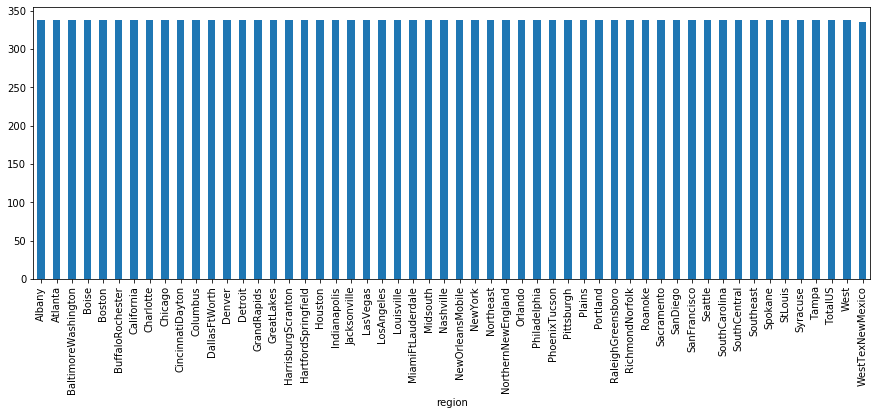

In [61]:
fig = df['region'].groupby(df["region"]).count().plot(kind="bar",figsize=(15, 5))

# Realizar una gráfica de barras para ver de qué años se tiene información

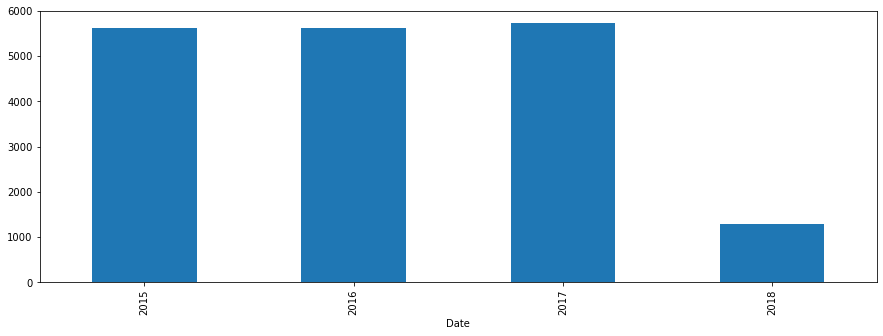

In [62]:
fig = df['Date'].groupby([df["Date"].dt.year]).count().plot(kind="bar",figsize=(15, 5))

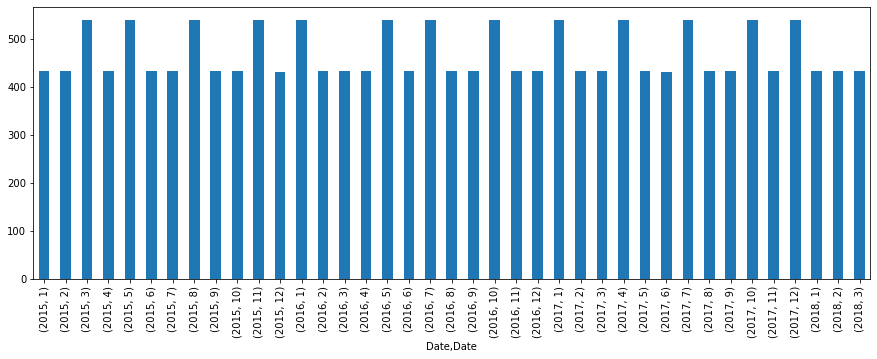

In [63]:
fig = df['Date'].groupby([df["Date"].dt.year, df["Date"].dt.month]).count().plot(kind="bar",figsize=(15, 5))


In [66]:
dfOrg = df[df['type'] == 'organic']
dfConv = df[df['type'] == 'conventional']

# Preparar los datos para que se acoplen a lo que requiere el modelo a utilizar

In [14]:
df['Month'] = pd.DatetimeIndex(df['Date'])
df.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
Month           datetime64[ns]
dtype: object

In [15]:
df = df.rename(columns={'Month': 'ds',
                        'AveragePrice': 'y'})

df = df[['ds','y']]
df.tail(10)

,ds,y
8526,2018-03-25,1.39
17841,2018-03-25,1.75
18057,2018-03-25,1.42
8850,2018-03-25,1.32
17649,2018-03-25,1.74
8574,2018-03-25,1.36
9018,2018-03-25,0.70
18141,2018-03-25,1.42
17673,2018-03-25,1.70
8814,2018-03-25,1.34


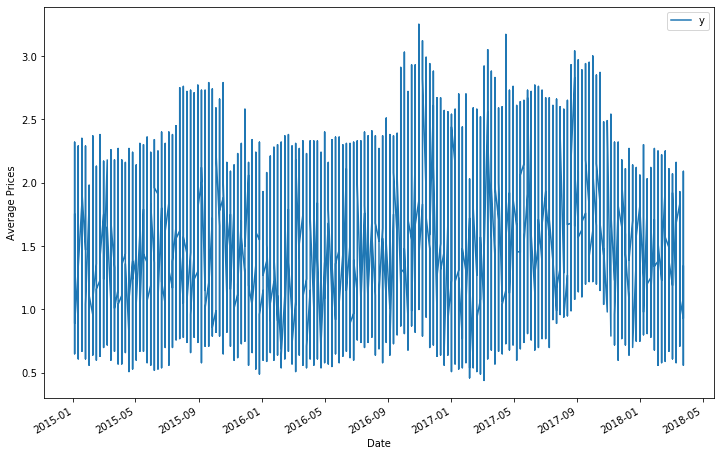

In [16]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Average Prices')
ax.set_xlabel('Date')

plt.show()

## ------------------------------------------------------ Organic -----------------------------------------------------

## --------------------------------------------------------- Prophet ---------------------------------------------------------

# Creación y ajuste del modelo

In [17]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95)

In [18]:
mi_modelo.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Realizar predicciones

In [19]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=12, freq='MS')
fechas_futuras.tail()

,ds
176,2018-11-01
177,2018-12-01
178,2019-01-01
179,2019-02-01
180,2019-03-01


In [20]:
prediccion = mi_modelo.predict(fechas_futuras)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Pronosticar hacia el futuro un año (365 días)

In [21]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2018-11-01,1.381160,0.654366,2.112392
177,2018-12-01,1.225343,0.452456,2.028800
178,2019-01-01,1.107466,0.360312,1.887439
179,2019-02-01,1.047810,0.282286,1.826398
180,2019-03-01,1.082373,0.292979,1.821019


# Graficar datos históricos y pronosticados

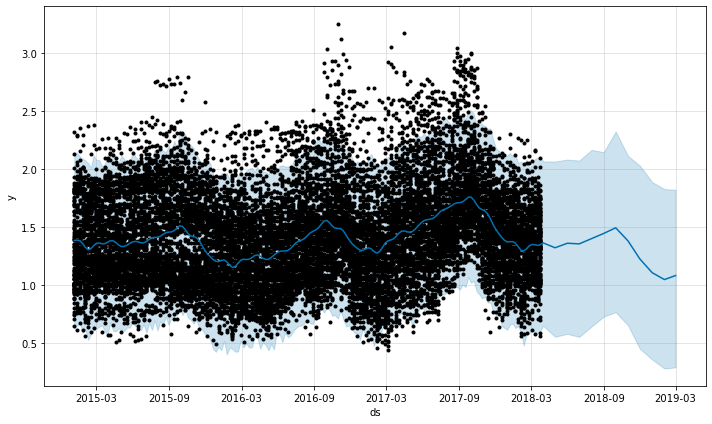

In [22]:
mi_modelo.plot(prediccion,
               uncertainty=True);

In [68]:
dfOrg['Month'] = pd.DatetimeIndex(dfOrg['Date'])
dfOrg.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
y                      float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
Month           datetime64[ns]
dtype: object

In [70]:
dfOrg = dfOrg.rename(columns={'Month': 'ds',
                        'AveragePrice': 'y'})

dfOrg = dfOrg[['ds','y']]
dfOrg.tail(10)

,ds,y
18045,2018-03-25,2.02
17829,2018-03-25,1.28
17661,2018-03-25,1.03
17925,2018-03-25,1.36
18153,2018-03-25,1.45
17841,2018-03-25,1.75
18057,2018-03-25,1.42
17649,2018-03-25,1.74
18141,2018-03-25,1.42
17673,2018-03-25,1.70


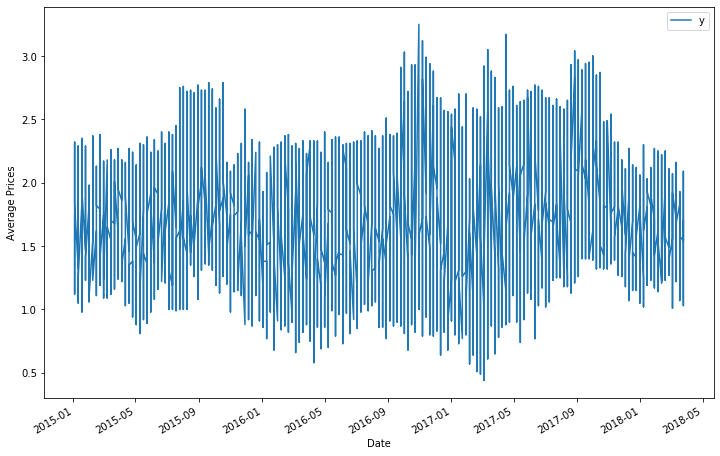

In [72]:
ax = dfOrg.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Average Prices')
ax.set_xlabel('Date')

plt.show()

## --------------------------------------------------------- Prophet ---------------------------------------------------------

# ------------------------------------------------ Organic -------------------------------------------------

# Creación y ajuste del modelo

In [73]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95)

In [74]:
mi_modelo.fit(dfOrg)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Realizar predicciones

In [75]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=12, freq='MS')
fechas_futuras.tail()

,ds
176,2018-11-01
177,2018-12-01
178,2019-01-01
179,2019-02-01
180,2019-03-01


In [76]:
prediccion = mi_modelo.predict(fechas_futuras)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Pronosticar hacia el futuro un año (365 días)

In [77]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2018-11-01,1.641456,0.915159,2.309594
177,2018-12-01,1.493265,0.819732,2.193455
178,2019-01-01,1.375773,0.623025,2.025590
179,2019-02-01,1.341771,0.617138,2.041652
180,2019-03-01,1.318914,0.609850,2.007328


# Graficar datos históricos y pronosticados

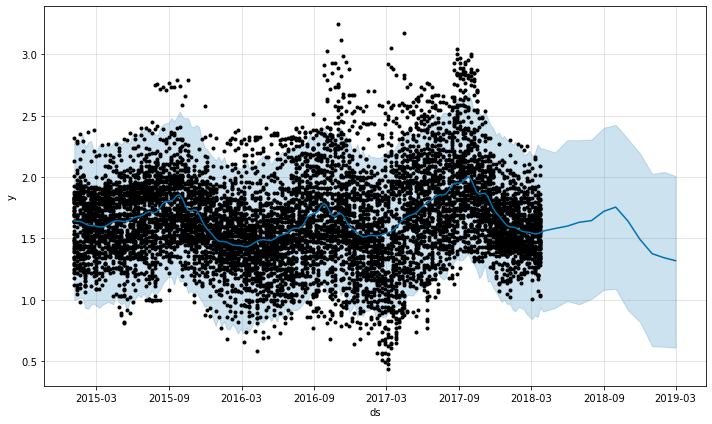

In [78]:
mi_modelo.plot(prediccion,
               uncertainty=True);

## --------------------------------------------------------- Conventional --------------------------------------------------------

# Preparar los datos para que se acoplen a lo que requiere el modelo a utilizar

In [80]:
dfConv['Month'] = pd.DatetimeIndex(dfConv['Date'])
dfConv.dtypes

C:\Users\carlo\AppData\Local\Temp\ipykernel_18364\4195015709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfConv['Month'] = pd.DatetimeIndex(dfConv['Date'])


Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
Month           datetime64[ns]
dtype: object

In [81]:
dfConv = dfConv.rename(columns={'Month': 'ds',
                        'AveragePrice': 'y'})

dfConv = dfConv[['ds','y']]
dfConv.tail(10)

,ds,y
8994,2018-03-25,1.40
8502,2018-03-25,1.23
8586,2018-03-25,1.08
8730,2018-03-25,1.01
8862,2018-03-25,1.31
8526,2018-03-25,1.39
8850,2018-03-25,1.32
8574,2018-03-25,1.36
9018,2018-03-25,0.70
8814,2018-03-25,1.34


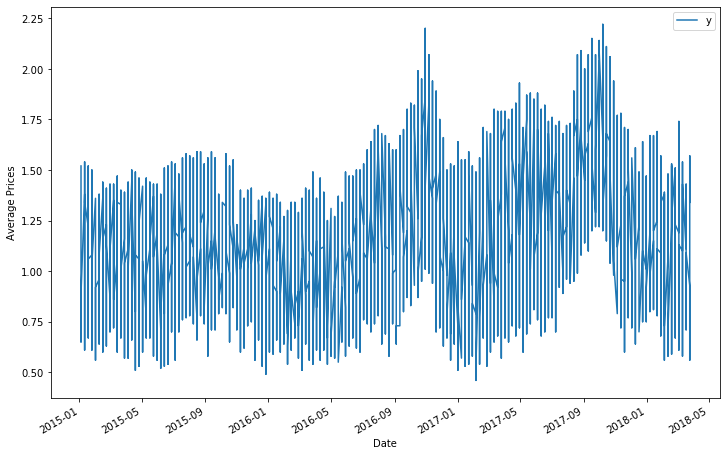

In [82]:
ax = dfConv.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Average Prices')
ax.set_xlabel('Date')

plt.show()

# Creación y ajuste del modelo

In [95]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95,weekly_seasonality=True)

In [96]:
mi_modelo.fit(dfConv)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Realizar predicciones

In [97]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=12, freq='MS')
fechas_futuras.tail()

,ds
176,2018-11-01
177,2018-12-01
178,2019-01-01
179,2019-02-01
180,2019-03-01


In [98]:
prediccion = mi_modelo.predict(fechas_futuras)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Pronosticar hacia el futuro un año (365 días)

In [99]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2018-11-01,1.258852,0.788862,1.707862
177,2018-12-01,1.094433,0.646961,1.580955
178,2019-01-01,0.976662,0.444995,1.538480
179,2019-02-01,0.892443,0.367534,1.440843
180,2019-03-01,0.986737,0.375174,1.559246


# Graficar datos históricos y pronosticados

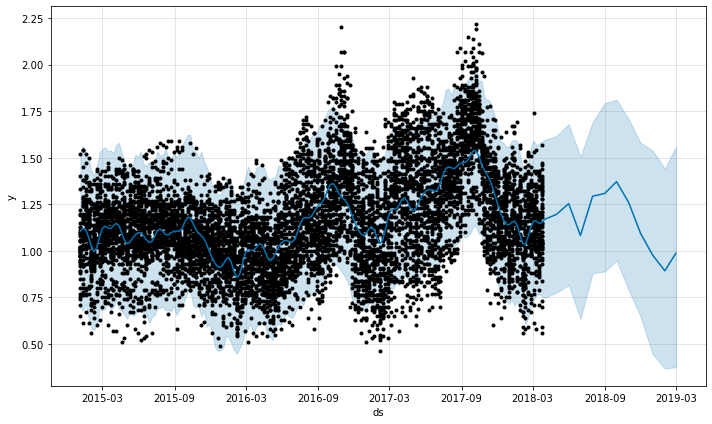

In [100]:
mi_modelo.plot(prediccion,
               uncertainty=True);

# PARTE 2

### Repetir el ejercicio pero solo con la región oeste "West" de los EEUU

### Leer el archivo de datos

In [101]:
dfWest = pd.read_csv('aguacates_EEUU.csv')

In [102]:
dfWest = dfWest[dfWest['region'] == 'West']

In [103]:
dfWest.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

Convertimos la columna fecha en tipo fecha

In [104]:
dfWest['Date'] = pd.to_datetime(dfWest['Date'])

In [105]:
dfWest.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
dtype: object

# Asegurar que estén los datos en orden cronológico

In [106]:
dfWest = dfWest.sort_values('Date')
dfWest

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
2755,51,2015-01-04,0.89,5794410.58,2275446.87,2582300.65,97024.09,839638.97,688813.01,150819.57,6.39,conventional,2015,West
11881,51,2015-01-04,1.40,187548.30,70313.71,72942.11,24.30,44268.18,10023.72,34244.46,0.00,organic,2015,West
2754,50,2015-01-11,0.95,5333097.71,2203111.92,2292761.26,127412.09,709812.44,598705.08,111073.82,33.54,conventional,2015,West
11880,50,2015-01-11,1.39,223156.55,80139.16,111395.01,63.88,31558.50,9296.76,22261.74,0.00,organic,2015,West
2753,49,2015-01-18,0.96,5475363.01,2431736.63,2258069.63,76348.13,709208.62,527358.78,181809.88,39.96,conventional,2015,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18227,2,2018-03-11,1.63,264691.87,27566.25,60383.57,276.42,176465.63,107174.93,69290.70,0.00,organic,2018,West
18226,1,2018-03-18,1.73,210067.47,33437.98,47165.54,110.40,129353.55,73163.12,56020.24,170.19,organic,2018,West
9103,1,2018-03-18,0.99,7254940.65,2099082.66,1707752.84,115997.93,3332107.22,1333247.05,1982086.02,16774.15,conventional,2018,West
9102,0,2018-03-25,0.93,7667064.46,2567279.74,1912986.38,118289.91,3068508.43,1309580.19,1745630.06,13298.18,conventional,2018,West


# Graficar el precio promedio vs fecha

### ¿Es diferente la tendencia comparado a la tendencia nacional?

Object `nacional` not found.


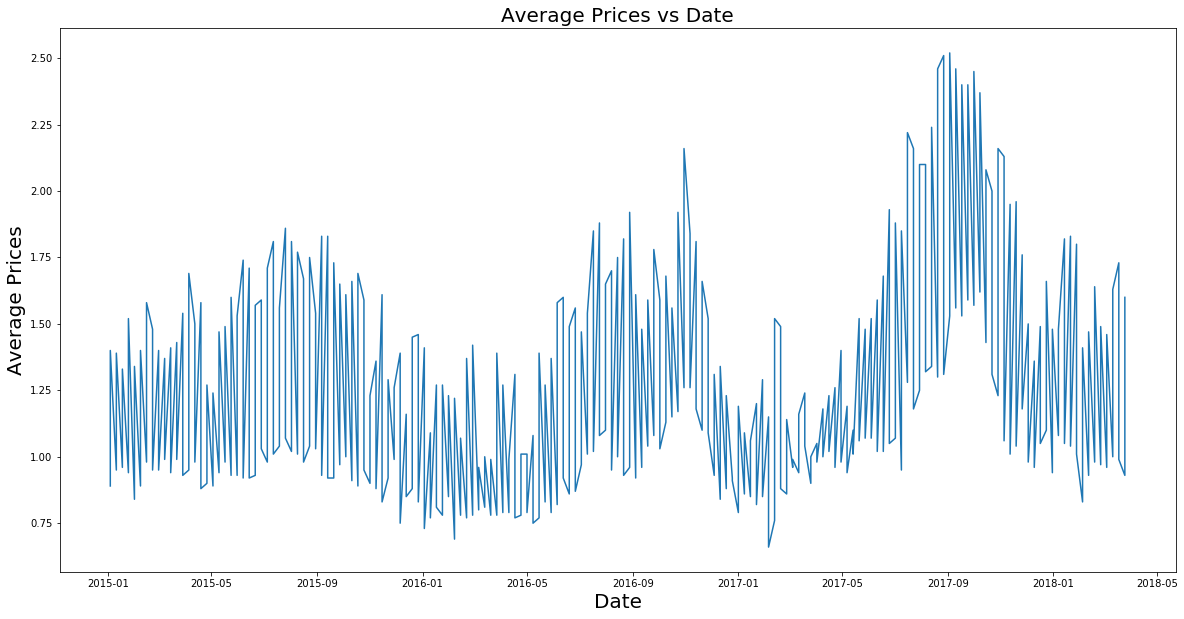

In [37]:
# Realizar una gráfica de precios promedio vrs fecha

¿Cuál es la tendencia a nivel nacional?

plt.figure(figsize=(20,10))
plt.plot(dfWest['Date'],dfWest['AveragePrice'])
plt.title('Average Prices vs Date',size = 20)
plt.xlabel('Date',size = 20)
plt.ylabel('Average Prices',size = 20)
plt.show()

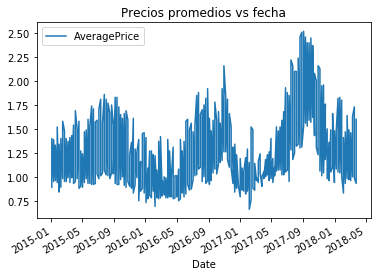

In [38]:
dfWest.plot(x ='Date', y= 'AveragePrice', title = 'Precios promedios vs fecha')

# Realizar una gráfica de barras para ver de qué años se tiene información

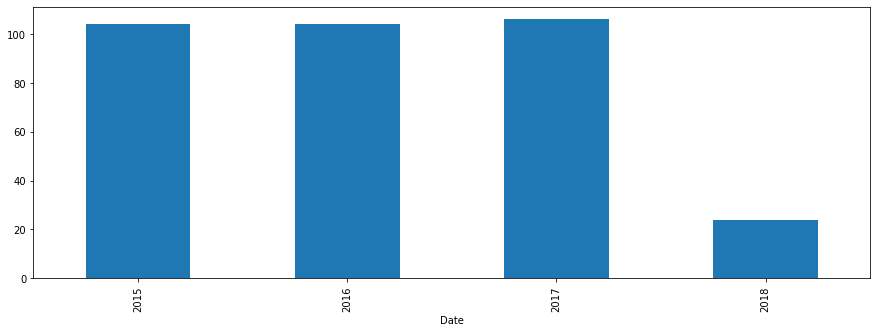

In [40]:
fig = dfWest['Date'].groupby([dfWest["Date"].dt.year]).count().plot(kind="bar",figsize=(15, 5))

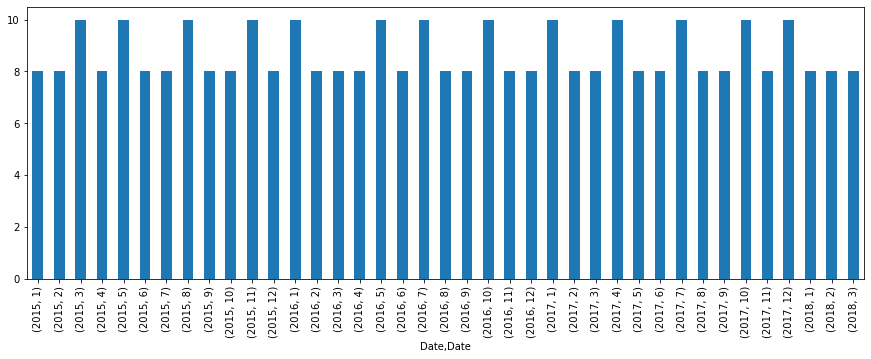

In [41]:
fig = dfWest['Date'].groupby([dfWest["Date"].dt.year, dfWest["Date"].dt.month]).count().plot(kind="bar",figsize=(15, 5))


# Preparar los datos para que se acoplen a lo que requiere el modelo a utilizar

In [42]:
dfWest['Month'] = pd.DatetimeIndex(dfWest['Date'])
dfWest.dtypes

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
Month           datetime64[ns]
dtype: object

In [117]:
dfOrg = dfWest[dfWest['type'] == 'organic']
dfConv = dfWest[dfWest['type'] == 'conventional']

In [43]:
dfWest = dfWest.rename(columns={'Month': 'ds',
                        'AveragePrice': 'y'})
dfWest = dfWest[['ds','y']]
dfWest.tail(10)

,ds,y
9106,2018-02-25,0.97
18229,2018-02-25,1.49
9105,2018-03-04,0.96
18228,2018-03-04,1.46
9104,2018-03-11,1.00
18227,2018-03-11,1.63
18226,2018-03-18,1.73
9103,2018-03-18,0.99
9102,2018-03-25,0.93
18225,2018-03-25,1.60


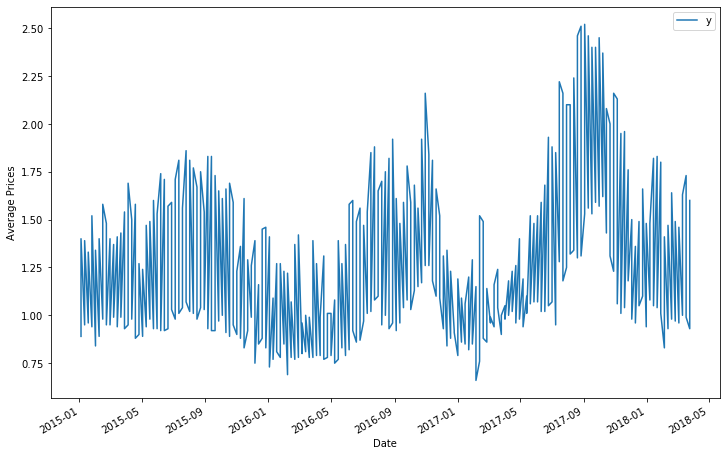

In [44]:
ax = dfWest.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Average Prices')
ax.set_xlabel('Date')

plt.show()

## --------------------------------------------------------- Prophet ---------------------------------------------------------

# Creación y ajuste del modelo

In [45]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95)

In [46]:
mi_modelo.fit(dfWest)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Realizar predicciones

In [47]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=12, freq='MS')
fechas_futuras.tail()

,ds
176,2018-11-01
177,2018-12-01
178,2019-01-01
179,2019-02-01
180,2019-03-01


In [48]:
prediccion = mi_modelo.predict(fechas_futuras)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Pronosticar hacia el futuro un año (365 días)

In [49]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2018-11-01,1.819285,1.228223,2.453739
177,2018-12-01,1.566518,0.966721,2.189739
178,2019-01-01,1.498424,0.838785,2.152225
179,2019-02-01,1.516745,0.826891,2.208261
180,2019-03-01,1.549721,0.877258,2.242108


# Graficar datos históricos y pronosticados

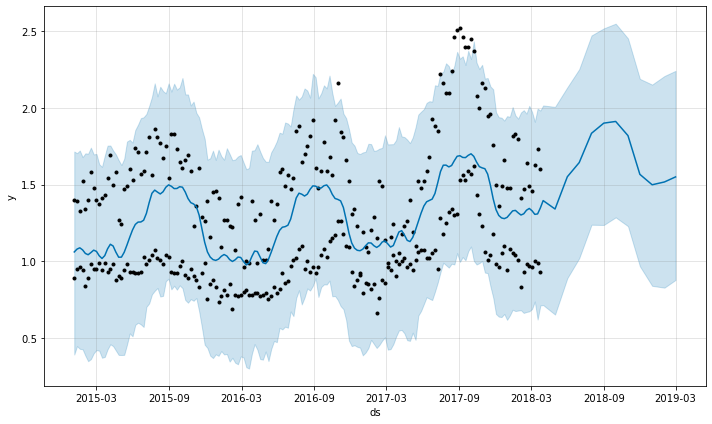

In [50]:
mi_modelo.plot(prediccion,
               uncertainty=True);

## ------------------------------------------------------ Organic -----------------------------------------------------

In [119]:
dfOrg = dfOrg.rename(columns={'Month': 'ds',
                        'AveragePrice': 'y'})
dfOrg = dfOrg[['ds','y']]
dfOrg.tail(10)

,ds,y
18234,2018-01-21,1.83
18233,2018-01-28,1.80
18232,2018-02-04,1.41
18231,2018-02-11,1.47
18230,2018-02-18,1.64
18229,2018-02-25,1.49
18228,2018-03-04,1.46
18227,2018-03-11,1.63
18226,2018-03-18,1.73
18225,2018-03-25,1.60


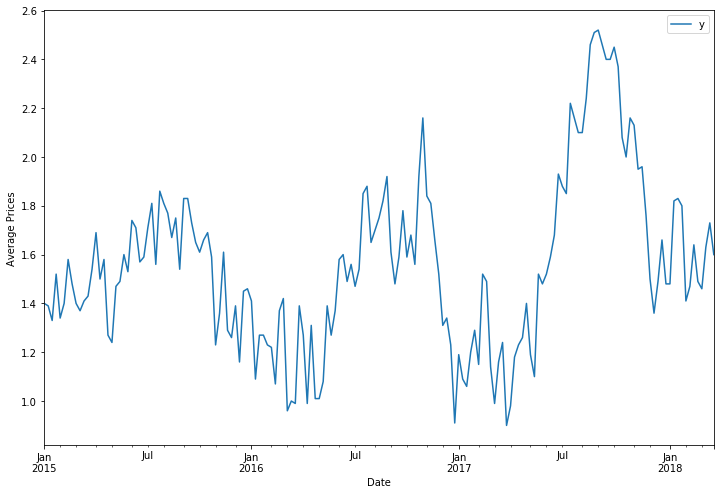

In [121]:
ax = dfOrg.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Average Prices')
ax.set_xlabel('Date')

plt.show()

# Creación y ajuste del modelo

In [149]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95,weekly_seasonality=True)

In [150]:
mi_modelo.fit(dfOrg)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Realizar predicciones

In [151]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=12, freq='MS')
fechas_futuras.tail()

,ds
176,2018-11-01
177,2018-12-01
178,2019-01-01
179,2019-02-01
180,2019-03-01


In [152]:
prediccion = mi_modelo.predict(fechas_futuras)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Pronosticar hacia el futuro un año (365 días)

In [153]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2018-11-01,2.199316,1.877957,2.548530
177,2018-12-01,1.807292,1.478445,2.141781
178,2019-01-01,1.723608,1.366427,2.062000
179,2019-02-01,1.791088,1.452505,2.112289
180,2019-03-01,1.779206,1.428694,2.105962


# Graficar datos históricos y pronosticados

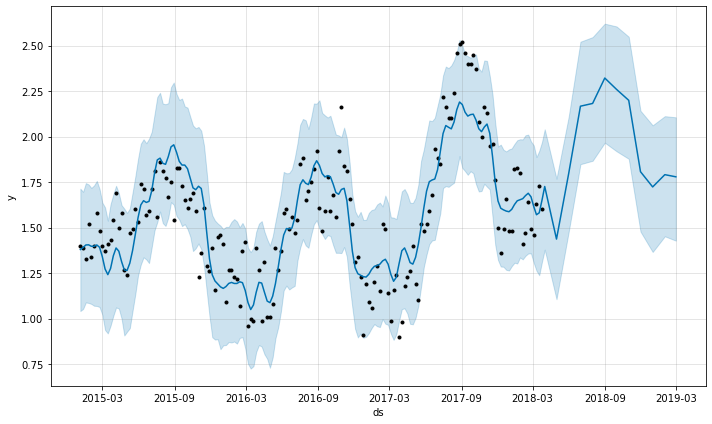

In [154]:
mi_modelo.plot(prediccion,
               uncertainty=True);

## --------------------------------------------------------- Conventional --------------------------------------------------------

# Preparar los datos para que se acoplen a lo que requiere el modelo a utilizar

In [128]:
dfConv['Month'] = pd.DatetimeIndex(dfConv['Date'])
dfConv.dtypes

C:\Users\carlo\AppData\Local\Temp\ipykernel_18364\4195015709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfConv['Month'] = pd.DatetimeIndex(dfConv['Date'])


Unnamed: 0               int64
Date            datetime64[ns]
y                      float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
Month           datetime64[ns]
dtype: object

In [129]:
dfConv = dfConv.rename(columns={'Month': 'ds',
                        'AveragePrice': 'y'})

dfConv = dfConv[['ds','y']]
dfConv.tail(10)

,ds,y
9111,2018-01-21,1.04
9110,2018-01-28,1.01
9109,2018-02-04,0.83
9108,2018-02-11,0.93
9107,2018-02-18,0.98
9106,2018-02-25,0.97
9105,2018-03-04,0.96
9104,2018-03-11,1.00
9103,2018-03-18,0.99
9102,2018-03-25,0.93


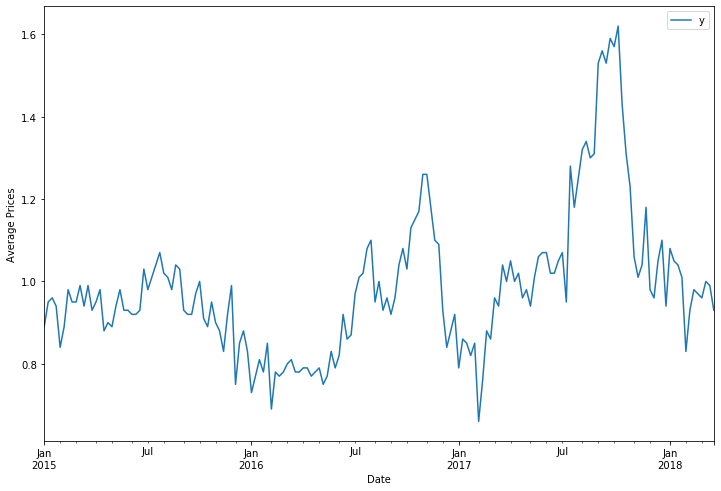

In [130]:
ax = dfConv.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Average Prices')
ax.set_xlabel('Date')

plt.show()

# Creación y ajuste del modelo

In [131]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95,weekly_seasonality=True)

In [132]:
mi_modelo.fit(dfConv)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Realizar predicciones

In [133]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=12, freq='MS')
fechas_futuras.tail()

,ds
176,2018-11-01
177,2018-12-01
178,2019-01-01
179,2019-02-01
180,2019-03-01


In [134]:
prediccion = mi_modelo.predict(fechas_futuras)

C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\carlo\anaconda3\envs\Series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Pronosticar hacia el futuro un año (365 días)

In [135]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2018-11-01,1.220577,1.038636,1.411337
177,2018-12-01,1.110151,0.930805,1.297751
178,2019-01-01,1.031809,0.843856,1.213882
179,2019-02-01,0.988709,0.784008,1.171506
180,2019-03-01,1.073339,0.882378,1.273584


# Graficar datos históricos y pronosticados

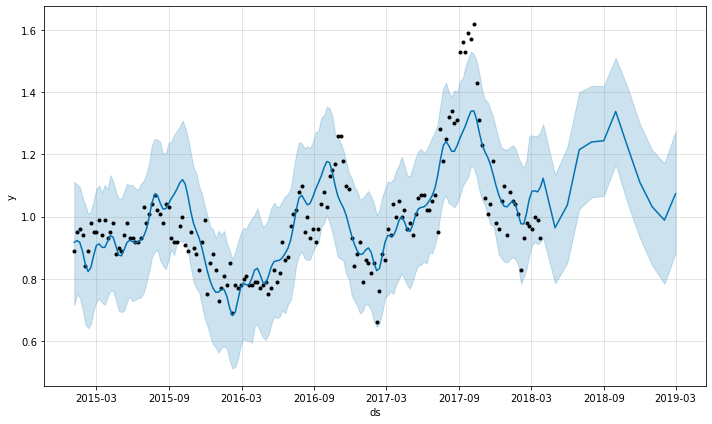

In [136]:
mi_modelo.plot(prediccion,
               uncertainty=True);